In [65]:
import json
import math
import pickle
import sys
import threading
import time
import traceback
from collections import defaultdict
from concurrent.futures.thread import ThreadPoolExecutor
import numpy as np
from elote import EloCompetitor
from katrain.core.constants import (
    AI_LOCAL,
    AI_RANK,
    AI_TENUKI,
    AI_WEIGHTED,
    AI_PICK,
    AI_TERRITORY,
    AI_POLICY,AI_INFLUENCE
)

from settings import Logger
import matplotlib.pyplot as plt

In [8]:
DB_FILENAME = "tournament_ai_performance.pickle"
class AI:
    pass

class FixedEloCompetitor(EloCompetitor):  # rating doesn't update on wins/losses
    pass
    
with open(DB_FILENAME, "rb") as f:
    ai_database,_ = pickle.load(f)

In [26]:
from sklearn.linear_model import LinearRegression
ranked = [ai for ai in ai_database if ai.strategy==AI_RANK]
calibrate = [ai for ai in ai_database if ai.strategy==AI_WEIGHTED]
policy = [ai for ai in ai_database if ai.strategy==AI_POLICY and ai.ai_settings['opening_moves']==0][0]
policy_elo = 1700
kyu_elo = [(r.ai_settings['kyu_rank'],r.elo_comp.rating) for r in ranked]
#kyu_elo.append( (-5,policy.elo_comp.rating) ) # policy ~5d
kyu_elo = sorted(kyu_elo)
kyu,elo = zip(*kyu_elo)


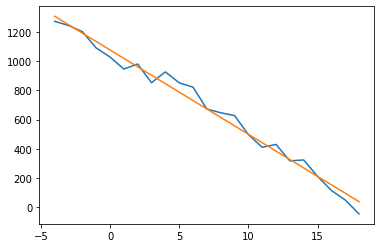

In [27]:
kyu2 = np.array(kyu)[:,np.newaxis]
reg = LinearRegression().fit(kyu2,elo)
plt.plot(kyu,elo,kyu,reg.predict(kyu2))

In [28]:
wt_elo =  [([r.ai_settings['weaken_fac']],r.elo_comp.rating) for r in calibrate]
x,y = zip(*wt_elo)
reg = LinearRegression().fit(x, y)
py = reg.predict(x)

In [29]:
plt.plot(x,y,x,py,x,ys)

NameError: name 'ys' is not defined

In [30]:
DB_FILENAME = "calibrated_ai_performance.jank.pickle"
with open(DB_FILENAME, "rb") as f:
    ai_database_jank,_ = pickle.load(f)

In [66]:
strat = AI_LOCAL
strat = AI_TENUKI
strat = AI_TERRITORY
strat = AI_INFLUENCE
local = [ai for ai in ai_database_jank if ai.strategy==strat]
loc_elo =  [([r.ai_settings['pick_frac'],r.ai_settings['pick_n']],min(policy_elo,r.elo_comp.rating)) for r in local]
loc,elo = zip(*loc_elo)

frac, n = zip(*loc)

In [67]:
frac_x = np.unique(frac)
n_y = np.unique(n)
matrix = np.zeros( (len(n_y),len(frac_x)) )

In [68]:
for (f,n),elo in loc_elo:
    xi, = np.where(frac_x==f)
    yi, = np.where(n_y==n)
    matrix[yi[0]][xi[0]] = elo
    

In [69]:
matrix

array([[1433.95918299,  483.92246022,  703.63329745,  898.80416596,
        1041.90611617, 1180.64701643, 1521.22844832, 1488.6024259 ],
       [ 285.94611239,  598.8780026 ,  673.84809013,  866.82639882,
        1032.48205655, 1334.28471216, 1502.55097318, 1571.77459082],
       [ 478.3702873 ,  643.86832596,  837.73488668,  945.32330087,
        1093.1194852 , 1396.09368572, 1484.49392758, 1564.14926031],
       [ 570.84132865,  689.70796295,  848.31920809, 1021.70892457,
        1143.30909057, 1371.45351738, 1507.48527553, 1592.641045  ],
       [ 749.49540671,  771.14405424,  865.1381579 , 1019.89505654,
        1107.95940949, 1383.37350536, 1508.29834616, 1549.81515732],
       [ 882.9691111 ,  902.88516506, 1057.30531618, 1178.39618159,
        1369.47479768, 1518.30319563, 1501.77213607, 1497.50803245]])

In [49]:
n_y

array([ 0,  5, 10, 15, 25, 50])